In [83]:
%matplotlib inline
from math import sqrt
from numpy import concatenate
from pandas import read_csv
from matplotlib import pyplot
from pandas import concat
from pandas import DataFrame
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [46]:
def series_to_supervised(data, n_in=1,n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (n_in, 0, -1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forcast sequence (t, t+1, .. t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)') % (j+1) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)') % (j+1, i) for j in range(n_vars) ]
    
    # put it all otgether
    agg = concat(cols, axis=1)
    agg.columns = names
    # dorp rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [5]:
dataset = read_csv('data/pollution.csv', header=0, index_col=0)
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


非数组转换成数字

In [26]:
#  风向转换为数字
encoder = LabelEncoder()
values = dataset.values
values[:,4] = encoder.fit_transform(values[:,4])

所有数字转换为浮点型

In [37]:
# 所有数字转换成float
values = values.astype('float32')

归一化(任意范围)

In [39]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [41]:
scaled[:4]

array([[ 0.12977867,  0.35294122,  0.24590163,  0.52727318,  0.66666669,
         0.00229001,  0.        ,  0.        ],
       [ 0.14889336,  0.36764708,  0.24590163,  0.52727318,  0.66666669,
         0.00381099,  0.        ,  0.        ],
       [ 0.15995975,  0.42647061,  0.22950819,  0.54545403,  0.66666669,
         0.00533197,  0.        ,  0.        ],
       [ 0.18209255,  0.48529413,  0.22950819,  0.56363678,  0.66666669,
         0.00839101,  0.03703704,  0.        ]], dtype=float32)

In [47]:
reframed = series_to_supervised(scaled, 1,1)

In [48]:
reframed[:4]

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0


In [50]:
# 只留下var1（1）做标记 ，其他标记都去掉
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

In [51]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


拆分成训练集和测试集

In [55]:
values2  = reframed.values
# 两年
n_train_hours = 365 * 24
train = values2[:n_train_hours,:]
test = values2[n_train_hours:,:]

1. 拆分称输入特征矩阵和标记向量   
2. 将训练集转换成LSTM的3D格式[samples,timpstamps, featrues] timestamps 表示要使用前几期来进行预测下一期。

In [59]:
train_X, train_Y = train[:, :-1], train[:,-1]
test_X, test_Y = test[:, :-1],test[:,-1]
train_X = train_X.reshape(train_X.shape[0],1,train_X.shape[1])
test_X = test_X.reshape(test_X.shape[0],1,test_X.shape[1])

构建网络模型

In [64]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae',optimizer='adam')

In [91]:
?LSTM

训练模型

In [65]:
history = model.fit(train_X, train_Y, epochs=50, batch_size=72, validation_data=(test_X, test_Y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 1s - loss: 0.0543 - val_loss: 0.0533
Epoch 2/50
 - 0s - loss: 0.0374 - val_loss: 0.0520
Epoch 3/50
 - 0s - loss: 0.0224 - val_loss: 0.0464
Epoch 4/50
 - 0s - loss: 0.0179 - val_loss: 0.0436
Epoch 5/50
 - 0s - loss: 0.0163 - val_loss: 0.0321
Epoch 6/50
 - 0s - loss: 0.0155 - val_loss: 0.0226
Epoch 7/50
 - 0s - loss: 0.0150 - val_loss: 0.0195
Epoch 8/50
 - 0s - loss: 0.0148 - val_loss: 0.0173
Epoch 9/50
 - 0s - loss: 0.0148 - val_loss: 0.0162
Epoch 10/50
 - 0s - loss: 0.0147 - val_loss: 0.0149
Epoch 11/50
 - 0s - loss: 0.0146 - val_loss: 0.0145
Epoch 12/50
 - 0s - loss: 0.0148 - val_loss: 0.0141
Epoch 13/50
 - 0s - loss: 0.0146 - val_loss: 0.0138
Epoch 14/50
 - 0s - loss: 0.0145 - val_loss: 0.0135
Epoch 15/50
 - 0s - loss: 0.0145 - val_loss: 0.0136
Epoch 16/50
 - 0s - loss: 0.0146 - val_loss: 0.0136
Epoch 17/50
 - 0s - loss: 0.0145 - val_loss: 0.0135
Epoch 18/50
 - 0s - loss: 0.0145 - val_loss: 0.0135
Epoch 19/50
 - 0s - loss

绘制训练误差和测试误差变化图

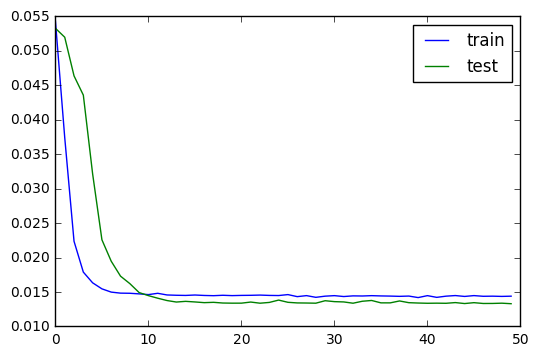

In [67]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

预测

In [76]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

逆归一化

In [88]:
# 预测值逆归一化
inv_yhat = concatenate((yhat,test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# 标记逆归一化
inv_Y = scaler.inverse_transform(test_X)
inv_Y = inv_Y[:,0]

计算RMSE

In [89]:
sqrt(mean_squared_error(inv_Y, inv_yhat))

3.908611834810375